In [15]:
import torch, cv2, os, glob
import albumentations as albu
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
import numpy as np

resolutions = ['1024x576', '720x405', '640x360'] # aspect ratio 16:9
DEVICE = 'cpu'
IMAGE_SIZE = 480 #640
IMAGE_WIDTH = 640
IMAGE_HEIGHT = 384 #480

ENCODER = 'resnet18'
ENCODER_WEIGHTS = 'imagenet'

model_path = 'weights/dlabv3p_resnet18_e25.pth'

In [28]:
def get_test_augmentation():
    return albu.Compose([
        # albu.Resize(IMAGE_SIZE, IMAGE_SIZE),
        albu.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    ])

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

def get_preprocessing(preprocessing_fn=None):
    """Construct preprocessing transform    
    Args:
        preprocessing_fn (callable): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """   
    _transform = []
        
    if preprocessing_fn:
        _transform.append(albu.Lambda(image=preprocessing_fn))

    _transform.append(albu.Lambda(name='to_tenzor', image=to_tensor, mask=to_tensor))
        
    return albu.Compose(_transform)

def visualize(image_name, filepath=None, **images):
    n = len(images)
    plt.figure(figsize=(18,8))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        if i == 0:
            plt.title(image_name)        
        else: 
            plt.title(' '.join(name.split('_')).title())        
        plt.imshow(image, interpolation='nearest')        
    if filepath:
        plt.savefig(filepath, bbox_inches='tight')
    plt.show()    
    
def files_in_subdirs(start_dir, pattern = ["*.png","*.jpg","*.jpeg"]):
    files = []
    for p in pattern:
        for dir,_,_ in os.walk(start_dir):
            files.extend(glob.glob(os.path.join(dir, p)))
    return files

### Loading model

In [4]:
# Number 1
model = torch.load(model_path, DEVICE)    
_ = model.eval()

In [8]:
image_path = 'd:/rzd_ai/datasets/Tests/obsticles/car_on_rails_00001.jpg'
image_name = os.path.splitext(os.path.basename(image_path))[0]
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image.shape

(1944, 2081, 3)

In [9]:
augmentor = get_test_augmentation()
preprocessor = get_preprocessing(preprocessing_fn)

img = augmentor(image=image)['image']
img = preprocessor(image=img)['image']
x_tensor = torch.from_numpy(img).to(DEVICE).unsqueeze(0)
pr_mask = model.predict(x_tensor)
print(f'input_tensor.shape={x_tensor.shape}, pred_mask.shape={pr_mask.shape}')

input_tensor.shape=torch.Size([1, 3, 384, 640]), pred_mask.shape=torch.Size([1, 4, 384, 640])


In [90]:
%%capture cap --no-stderr
pr_mask_railtrack = pr_mask.cpu().squeeze(0)[0,:,:].numpy().round()
pr_mask_railrised = pr_mask.cpu().squeeze(0)[1,:,:].numpy().round()
#pr_mask_railembedded = pr_mask.cpu().squeeze(0)[2,:,:].numpy().round()
#pr_mask_tramtrack = pr_mask.cpu().squeeze(0)[3,:,:].numpy().round()
#rail_mask = pr_mask.cpu().squeeze(0).amax(axis=0).round().numpy()#.astype(np.uint8)
rail_mask = np.amax(pr_mask.cpu().squeeze(0).numpy().round(), axis=0).astype(np.uint8)

visualize(image_name, f'images/{image_name}_seg.png', 
          image=image, 
          railtrack=pr_mask_railtrack, 
          raillines=pr_mask_railrised,
#          rail_embedded=pr_mask_railembedded,
#          tramtrack=pr_mask_tramtrack,
          track_and_lines=rail_mask, )

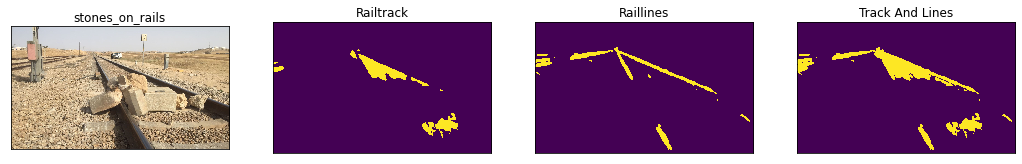

In [91]:
cap.show()

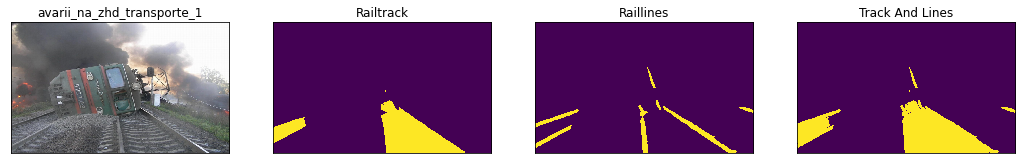

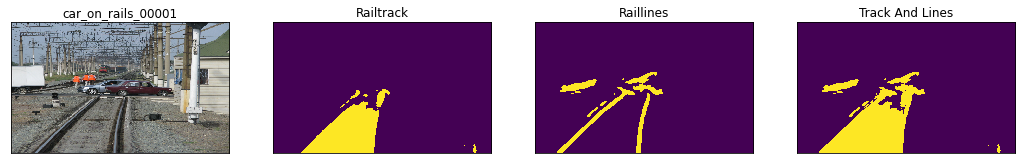

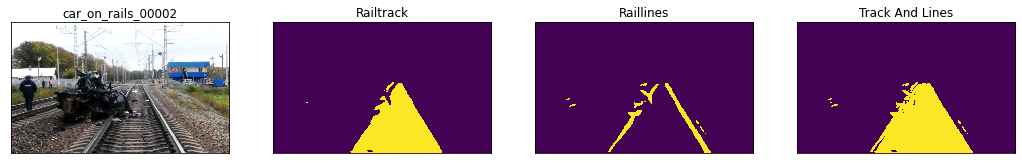

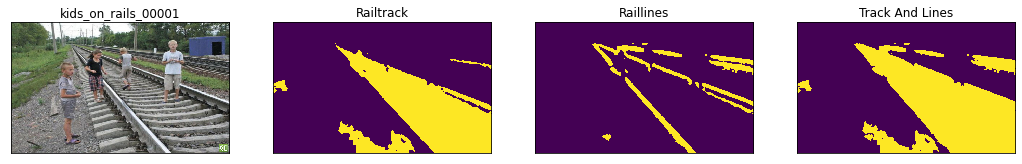

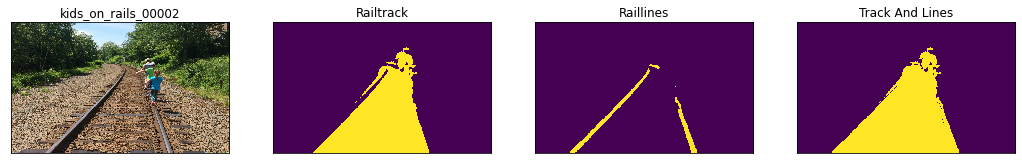

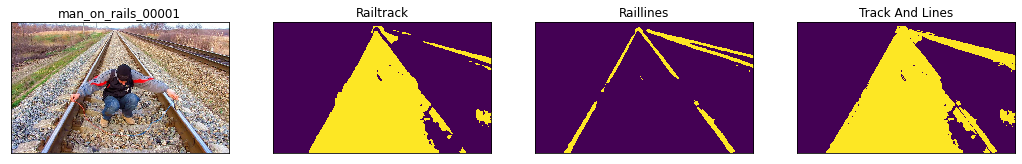

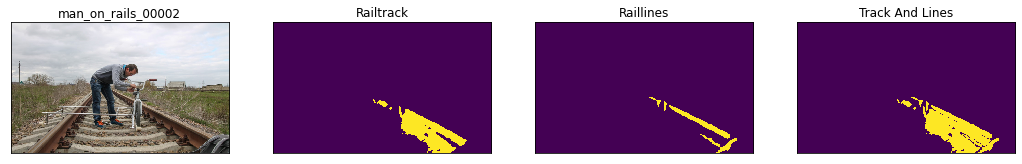

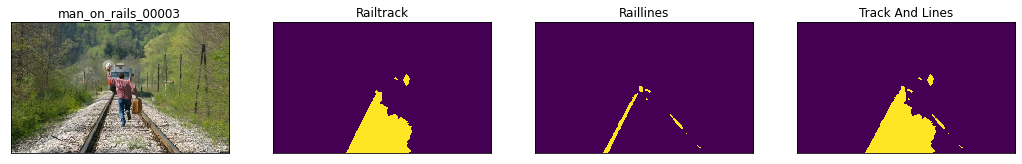

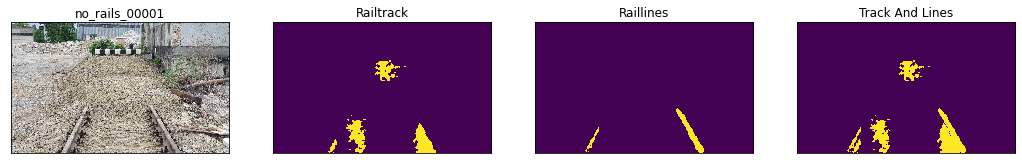

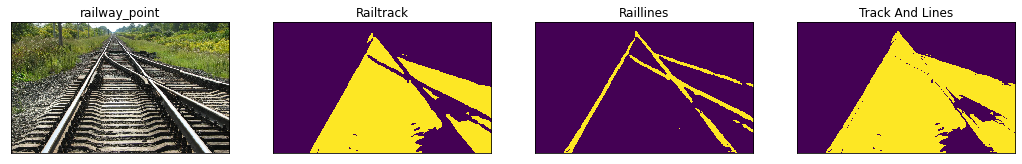

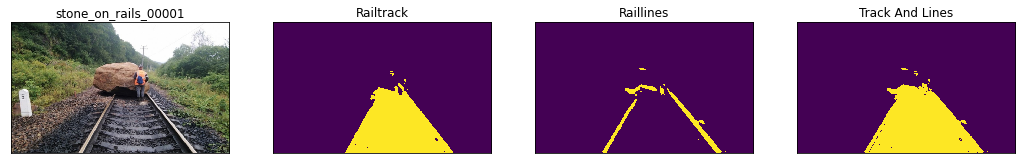

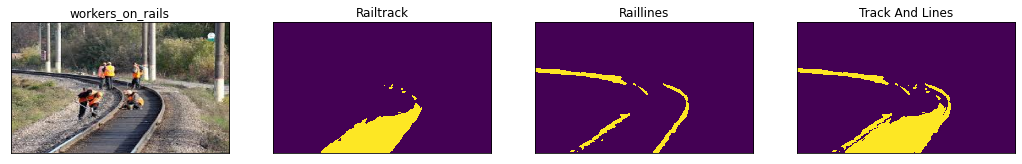

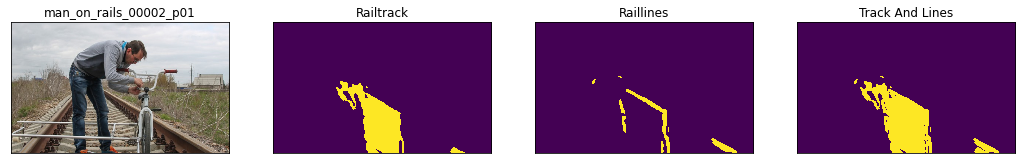

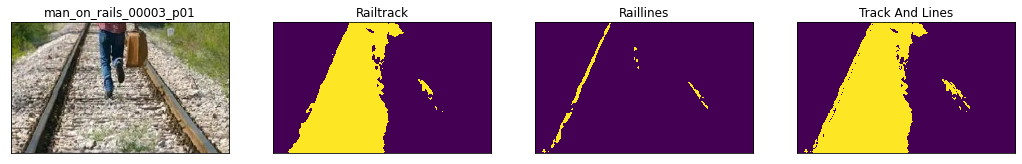

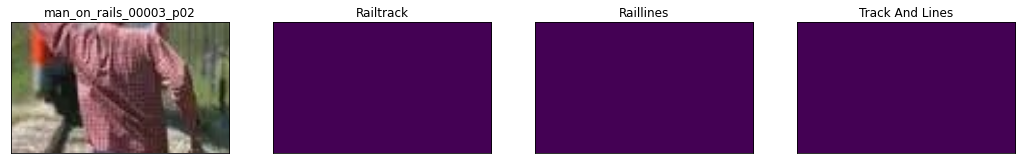

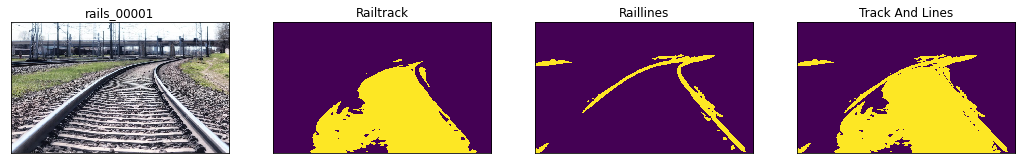

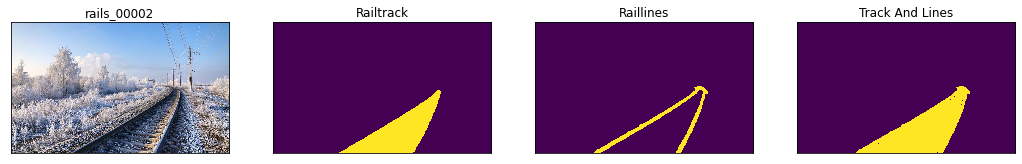

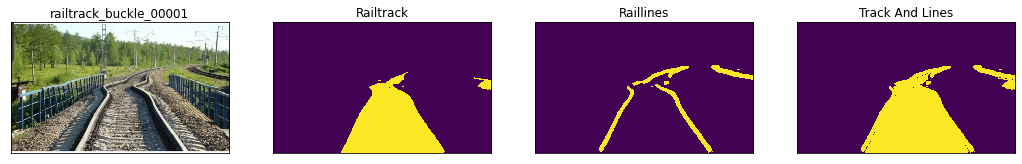

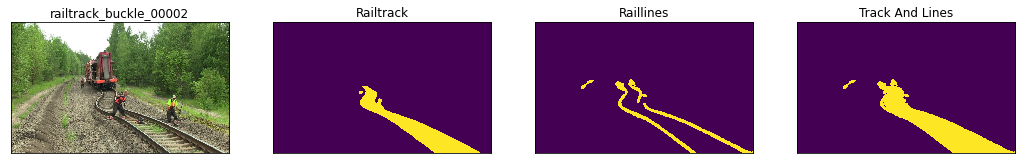

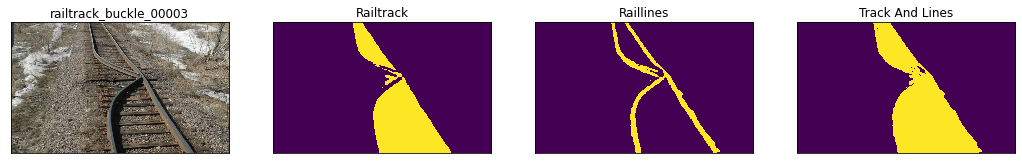

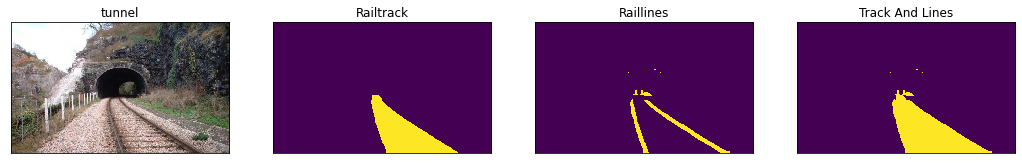

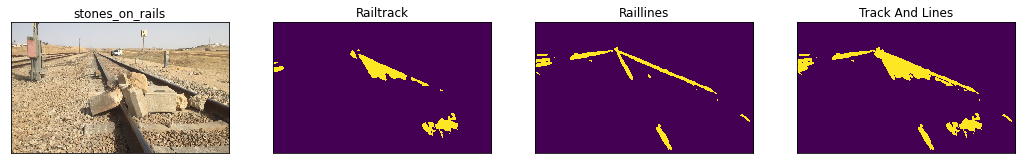

In [95]:
# %%capture cap --no-stderr
for image_path in files_in_subdirs('d:/rzd_ai/datasets/Tests'):
    # load image
    image_name = os.path.splitext(os.path.basename(image_path))[0]
    image = cv2.imread(image_path)
    if image is None:
        print(f'Cannot read image {image_path}')
        continue
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # predict
    img = augmentor(image=image)['image']
    img = preprocessor(image=img)['image']
    x_tensor = torch.from_numpy(img).to(DEVICE).unsqueeze(0)
    pr_mask = model.predict(x_tensor)
    # masks
    pr_mask_railtrack = pr_mask.cpu().squeeze(0)[0,:,:].numpy().round()
    pr_mask_railrised = pr_mask.cpu().squeeze(0)[1,:,:].numpy().round()
    rail_mask = np.amax(pr_mask.cpu().squeeze(0).numpy().round(), axis=0).astype(np.uint8)
    # visualize
    visualize(image_name, f'images/predictions/{image_name}_seg.png', 
          image=augmentor(image=image)['image'], 
          railtrack=pr_mask_railtrack, 
          raillines=pr_mask_railrised,
          track_and_lines=rail_mask, )   

#### Save cell output to png file

In [83]:
from PIL import Image
import io, base64

png_bytes = base64.b64decode(cap.outputs[0].data['image/png'])
img = Image.open(io.BytesIO(png_bytes))
img.save("images/semseg_tests.png")

In [87]:
len(cap.outputs)

17